# Titanic Machine Learning from Disaster

NOTE: All the analysis for this notebook is done with [Tableau](https://www.tableau.com/).

In [271]:
import re                                                                         # Regex
import pandas as pd                                                               # For DataFrame
import seaborn as sns                                                             # For Inhanced plotting
import matplotlib.pyplot as plt                                                   # For plots

from sklearn.preprocessing import LabelEncoder, OneHotEncoder                     # Encoders
from sklearn.model_selection import train_test_split, cross_validate              # Tools
from sklearn.ensemble import RandomForestClassifier                               # Random forest
from sklearn.svm import SVC, LinearSVC                                            # Support vector machines
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression    # More models
from sklearn.neighbors import KNeighborsClassifier                                # K-Nearest Neighbors model
from sklearn.naive_bayes import GaussianNB                                        # Gaussian model
from xgboost import XGBClassifier                                                 # XGBoost model

path = '/content/drive/MyDrive/Kaggle/Titanic-Machine-Learning-from-disaster/datasets/raw'

## Load Dataset

In [272]:
def read_data():
  train_df = pd.read_csv(f'{path}/train.csv')
  test_df = pd.read_csv(f'{path}/test.csv')  
  combine = [train_df, test_df]
  
  return train_df, test_df, combine

train_df, test_df, combine = read_data()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis (EDA)

In [273]:
# All features
print('All feafures:', list(train_df.columns))

# Ordinal features
print('Ordinal features:', list(train_df.select_dtypes(exclude = ['object']).columns))

# Categorical features
print('Categorical features:', list(train_df.select_dtypes(include = ['object']).columns))

All feafures: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Ordinal features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### Age Over Survived
By looking at the **Age** vs **Survived** analysis below, we can interpinterpret:
- Most passengers onboard are men.
- Most men and women are in their late 20s; However, most are men.
- We could turn **Age** to smaller bins (Why? there isn't really a difference between 21 and 21 year-olds)

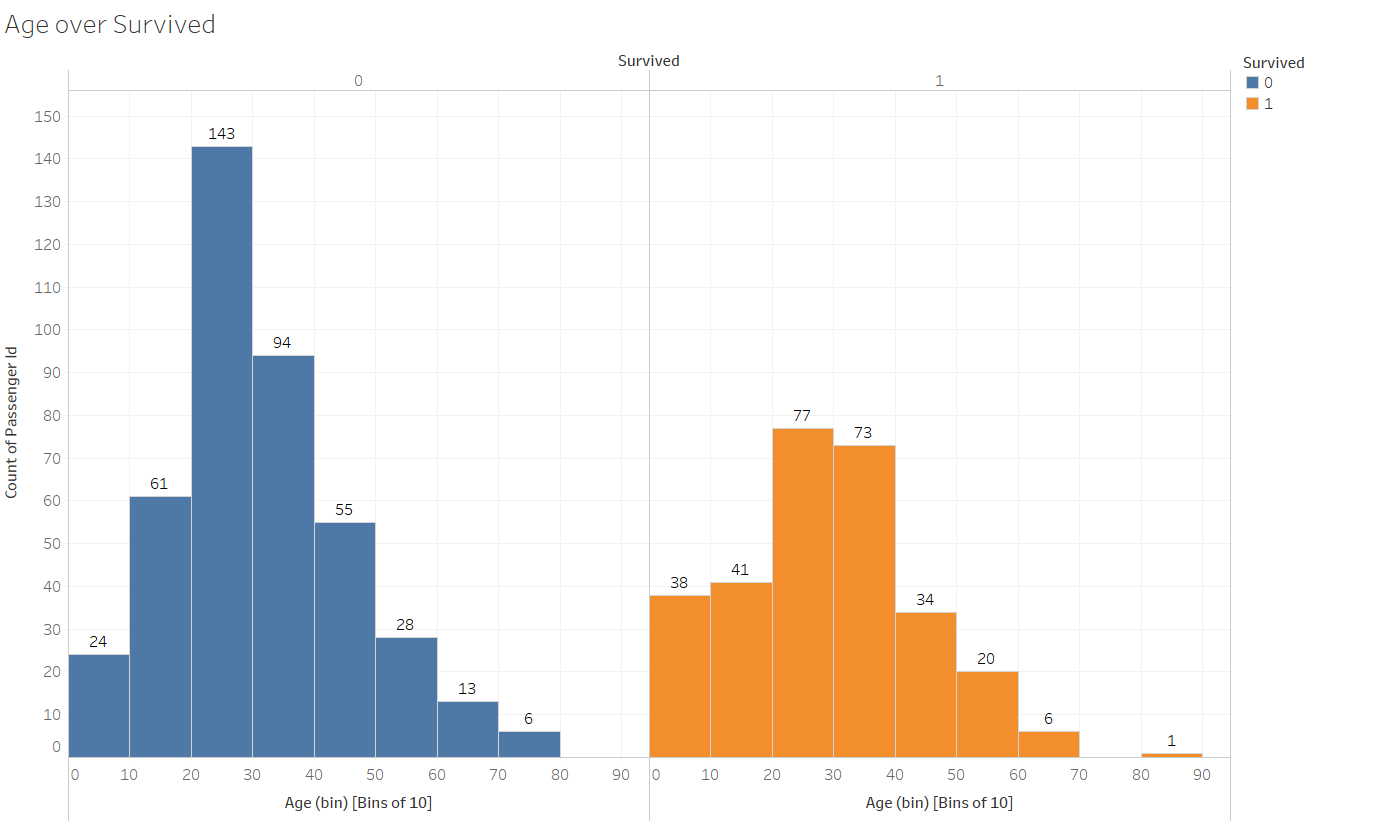

### Sex over Survived

We can understand the followings from the analysis below:
- Most men have not survived and most women have survived.
- **Sex** has an important role in predicting survival rate of the passengers.

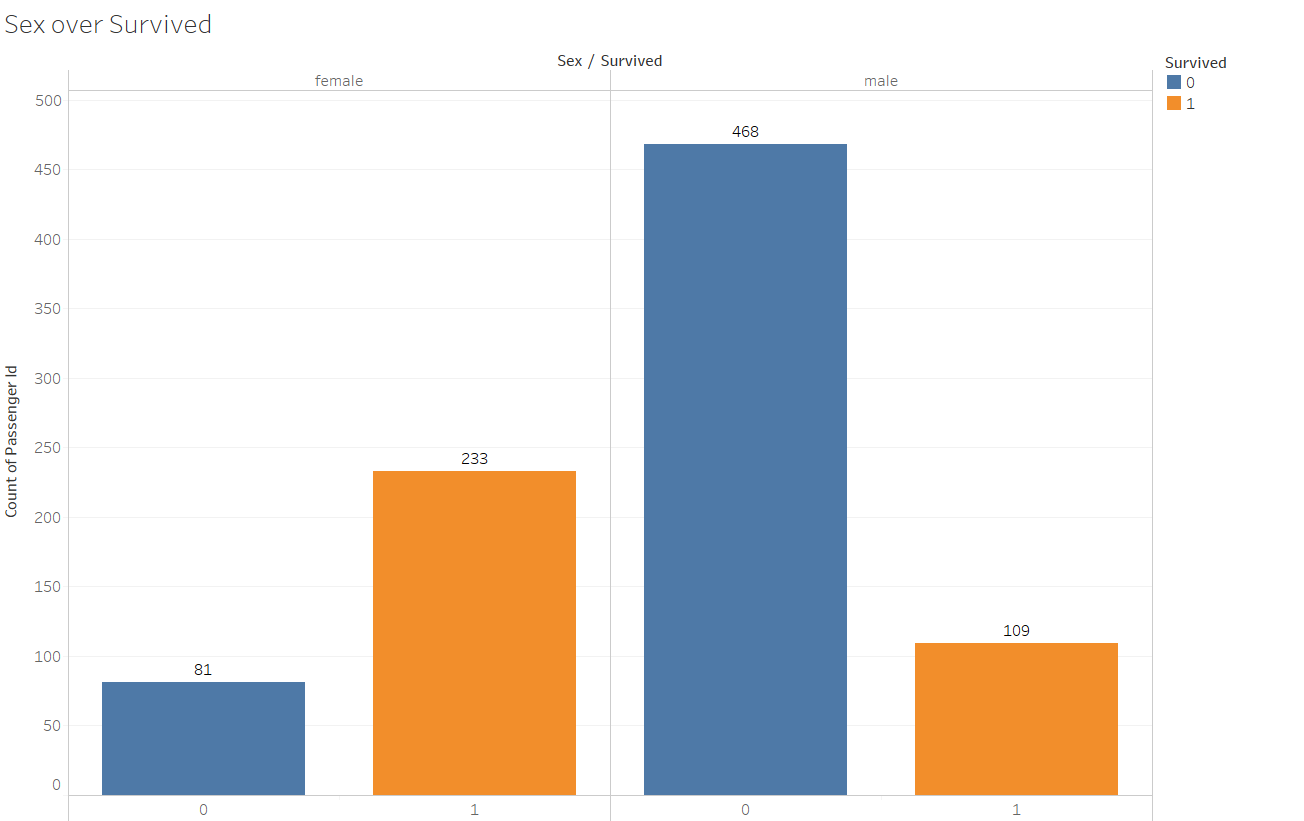

### Embarked over Survived

According to our statistics below, it is clear that:
- Most passengers embarked from port **C** have survived; However, this is not the case for port **Q**.
- Most passengers have embarked from port **S**. why? This can be related to the **PClass** feature.
- We have some **NULLs** in the dataset!

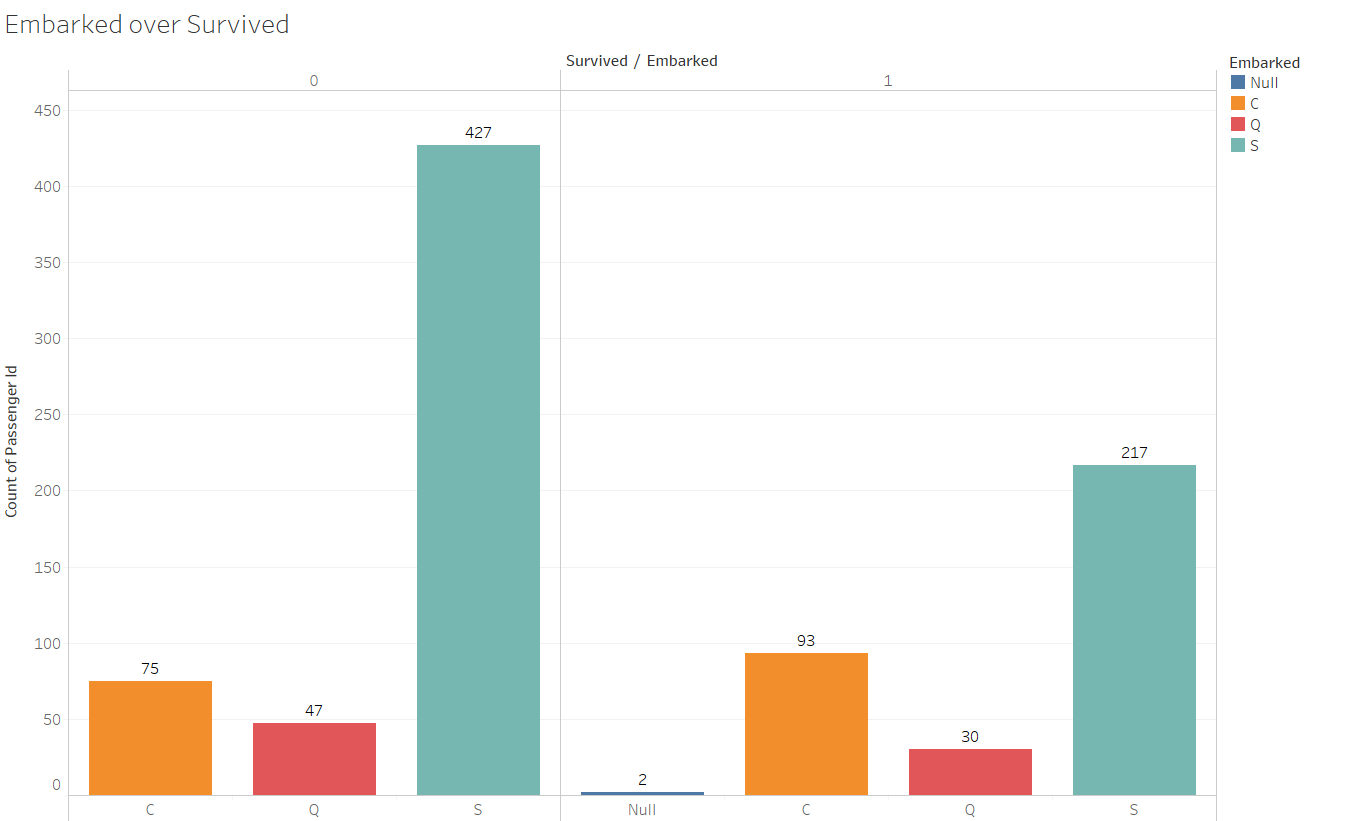

### FamilySize over Survived

The features **SibSp** and **Parch** are useful, but not in their raw forms. Logically speaking, you don't choose between your sibling or your parent in the middle of life and death crisis. So we better do a *Feature Extraction* and create a new feature called **FamilySize** with this formula:
`[Parch] + [SibSp] + 1`

If we don't add the `+1`, data wouldn't make sense beacuse each family requires atleast one member. Moreover:
- Families of size larger than 5 are not likely to have survived.
- If the person is alone, it's much less likely to have survived (2 out of every 3 alone people have died)
- The rate of death/survived decreases as the familySize increases (Portions become more balanced).
- FamilySizes of 2, 3 and 4 are more likely to survive!

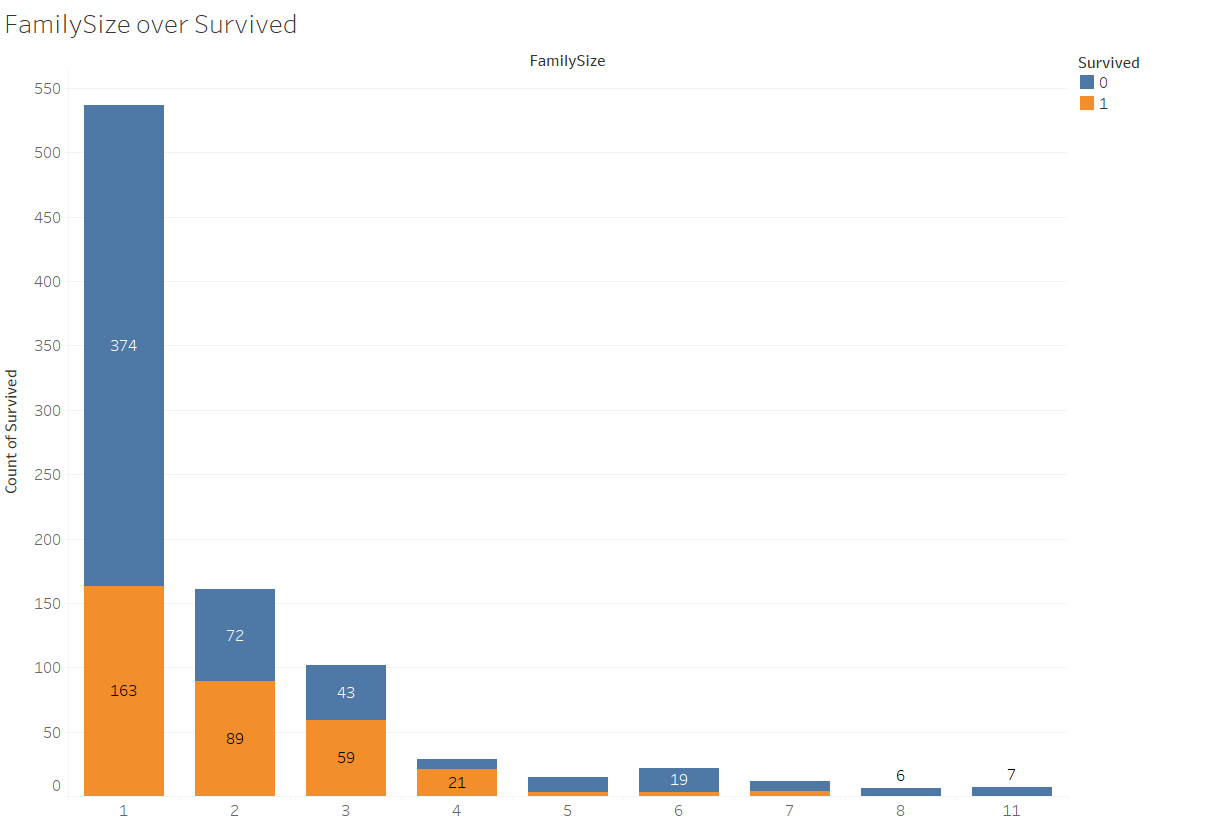

## Preprocessing

### Handle Missing Data

In [294]:
def handle_missing_data(df):

  # Fix Embakred
  df['Embarked'].fillna('S', inplace = True)

  # Remove Age
  df.dropna(subset = ['Age'], inplace = True)

### Feature Engineering

In [275]:
def feature_engineer(df, age_cuts, fare_cuts):

    # Construct a new feature for FamilySize
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

    # Construct a new feature for IsAlone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Construct Title feature
    df['Title'] = df['Name'].apply(lambda name: re.search(r'([A-Za-z]+)\.', name).group(0))

    df['Title'] = df['Title'].replace('Mlle.', 'Miss.')
    df['Title'] = df['Title'].replace('Ms', 'Miss.')
    df['Title'] = df['Title'].replace('Mme.', 'Mrs.')

    df['Title'] = df['Title'].apply(lambda x: 'Rare' if x not in ['Mr.', 'Miss.', 'Mrs.', 'Master.'] else x)

    # Create AgeBin
    df['AgeBin'] = pd.cut(df['Age'], age_cuts).values.astype(str)

    # Create FareBin
    df['FareBin'] = pd.qcut(df['Fare'], fare_cuts).values.astype(str)

### Drop Irrelevant Features

In [276]:
def drop_features(df, features):
  df.drop(columns = features, inplace = True)

### Encode Features

In [277]:
def encode_features(df, ordinal_features, categorical_features = None):

  # For ordinal features
  for feature in ordinal_features:
      encoder = LabelEncoder()
      train_df[feature] = encoder.fit_transform(train_df[feature])

  return df

### All In One

In [297]:
train_df, test_df, combine = read_data()

for df in combine:

  # Handle missing data
  handle_missing_data(df = df)

  # Feature Engineering
  feature_engineer(df = df, age_cuts = 5, fare_cuts = 4)

  # Encoding features
  encode_features(df = df, ordinal_features = ['AgeBin', 'FareBin', 'Pclass', 'Sex', 'Title', 'Embarked'])

  # Dropping irrelevent features
  combined = drop_features(df = df, features = ['Name', 'Ticket', 'Cabin', 'Age', 'Fare'])